In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt


# Load synthetic discharge data
data = pd.read_csv('synthetic_discharge_data.csv')

# Split data into training and testing sets (80% train, 20% test)
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Normalize the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Time', 'Voltage_measured', 'Current_measured', 
                                                     'Temperature_measured', 'Capacity']])
scaled_test_data = scaler.transform(test_data[['Time', 'Voltage_measured', 'Current_measured', 
                                               'Temperature_measured', 'Capacity']])

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert to PyTorch tensors (Training Data)
time_train = torch.tensor(scaled_train_data[:, 0], dtype=torch.float32).view(-1, 1).to(device)
voltage_train = torch.tensor(scaled_train_data[:, 1], dtype=torch.float32).view(-1, 1).to(device)
current_train = torch.tensor(scaled_train_data[:, 2], dtype=torch.float32).view(-1, 1).to(device)
temperature_train = torch.tensor(scaled_train_data[:, 3], dtype=torch.float32).view(-1, 1).to(device)
capacity_train = torch.tensor(scaled_train_data[:, 4], dtype=torch.float32).view(-1, 1).to(device)

# Convert to PyTorch tensors (Testing Data)
time_test = torch.tensor(scaled_test_data[:, 0], dtype=torch.float32).view(-1, 1).to(device)
voltage_test = torch.tensor(scaled_test_data[:, 1], dtype=torch.float32).view(-1, 1).to(device)
current_test = torch.tensor(scaled_test_data[:, 2], dtype=torch.float32).view(-1, 1).to(device)
temperature_test = torch.tensor(scaled_test_data[:, 3], dtype=torch.float32).view(-1, 1).to(device)
capacity_test = torch.tensor(scaled_test_data[:, 4], dtype=torch.float32).view(-1, 1).to(device)

# PINN model
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# Physics-informed loss function
def physics_loss(model, inputs, targets):
    # Data loss
    predictions = model(inputs)
    data_loss = nn.MSELoss()(predictions, targets)
    
    # Physics constraints
    time, voltage, current = inputs[:, 0:1], inputs[:, 1:2], inputs[:, 2:3]
    
    # Capacity degradation: Capacity = Cmax - k * time
    C_max = 1.0  # Normalized maximum capacity
    k = 0.00005  # Degradation rate
    predicted_capacity = C_max - k * time
    capacity_loss = nn.MSELoss()(predictions, predicted_capacity)
    
    # Ohm’s law: Voltage = Current * Resistance
    R_internal = 0.05  # Normalized internal resistance
    ohms_law = current * R_internal
    voltage_loss = nn.MSELoss()(voltage, ohms_law)
    
    # Total physics-informed loss
    total_loss = data_loss + capacity_loss + voltage_loss
    return total_loss

# Initialize the model
input_dim = 3  # Time, Voltage, Current
hidden_dim = 50
output_dim = 1  # Capacity
model = PINN(input_dim, hidden_dim, output_dim).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Prepare inputs and targets
    inputs = torch.cat([time_train, voltage_train, current_train], dim=1)
    targets = capacity_train
    
    # Compute physics-informed loss
    loss = physics_loss(model, inputs, targets)
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete.")

# Predicting on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_inputs = torch.cat([time_test, voltage_test, current_test], dim=1)
    predictions = model(test_inputs)

# Evaluate the performance
predictions_np = predictions.cpu().numpy()
capacity_test_np = capacity_test.cpu().numpy()

mse = mean_squared_error(capacity_test_np, predictions_np)
r2 = r2_score(capacity_test_np, predictions_np)

print(f"Test Mean Squared Error (MSE): {mse}")
print(f"Test R² Score: {r2}")


Using device: cuda
Epoch 0, Loss: 2.03974986076355
Epoch 1000, Loss: 0.4770183861255646
Epoch 2000, Loss: 0.4768931269645691
Epoch 3000, Loss: 0.4768837094306946
Epoch 4000, Loss: 0.4768819510936737
Training complete.
Test Mean Squared Error (MSE): 0.08052290230989456
Test R² Score: 0.00523453950881958


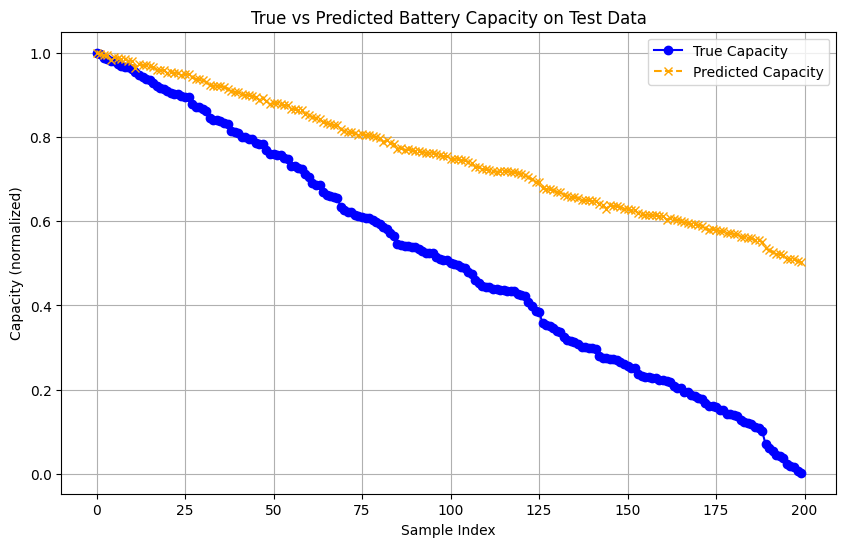

In [2]:

# Plot true vs predicted capacities
plt.figure(figsize=(10, 6))
plt.plot(capacity_test_np, label='True Capacity', color='blue', marker='o')
plt.plot(predictions_np, label='Predicted Capacity', color='orange', linestyle='dashed', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Capacity (normalized)')
plt.title('True vs Predicted Battery Capacity on Test Data')
plt.legend()
plt.grid()
plt.show()
